# SPARSE AUTO-ENCODER

In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
Important Link-https://web.stanford.edu/class/cs294a/sparseAutoencoder.pdf

In [4]:
mnist = input_data.read_data_sets("MNIST_data/")
trX, trY, teX, teY = mnist.train.images, mnist.train.labels,mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [5]:
def kl_div(self, rho, rho_hat):
    term2_num = tf.constant(1.)- rho
    term2_den = tf.constant(1.) - rho_hat
    kl = self.logfunc(rho,rho_hat) + self.logfunc(term2_num,
    term2_den)
    return kl
def logfunc(self, x1, x2):
    return tf.multiply( x1, tf.log(tf.div(x1,x2)))

In [15]:
class SparseAutoEncoder(object):
    def __init__(self, m, n, eta = 0.01):
        """
        m: Number of neurons in input/output layer
        n: number of neurons in hidden layer
        """
        self._m = m
        self._n = n
        self.learning_rate = eta
        # Create the Computational graph
        # Weights and biases
        self._W1 = tf.Variable(tf.random_normal(shape=(self._m,self._n)))
        self._W2 = tf.Variable(tf.random_normal(shape=(self._n,self._m)))
        self._b1 = tf.Variable(np.zeros(self._n).astype(np.float32)) 
        #bias for hidden layer
        self._b2 = tf.Variable(np.zeros(self._m).astype(np.float32))
        #bias for output layer
        
        # Placeholder for inputs
        self._X = tf.placeholder('float', [None, self._m])
        self.y = self.encoder(self._X)
        self.r = self.decoder(self.y)
        error = self._X - self.r
        self._loss = tf.reduce_mean(tf.pow(error, 2))
        alpha = 7.5e-5
        kl_div_loss = tf.reduce_sum(self.kl_div(0.02,tf.reduce_mean(self.y,0)))
        loss = self._loss + alpha * kl_div_loss
        self._opt = tf.train.AdamOptimizer(self.learning_rate).minimize(loss)
    def encoder(self, x):
        h = tf.matmul(x, self._W1) + self._b1
        return tf.nn.sigmoid(h)
    def decoder(self, x):
        h = tf.matmul(x, self._W2) + self._b2
        return tf.nn.sigmoid(h)
    def set_session(self, session):
        self.session = session
    def reduced_dimension(self, x):
        h = self.encoder(x)
        return self.session.run(h, feed_dict={self._X: x})
    def reconstruct(self,x):
        h = self.encoder(x)
        r = self.decoder(h)
        return self.session.run(r, feed_dict={self._X: x})
    def logfunc(self, x1, x2):
        return tf.multiply( x1, tf.log(tf.div(x1,x2)))
    def kl_div(self, rho, rho_hat):
        term2_num = tf.constant(1.)- rho
        term2_den = tf.constant(1.) - rho_hat
        kl = self.logfunc(rho,rho_hat) + self.logfunc(term2_num,term2_den)
        return kl
    def fit(self, X, epochs = 1, batch_size = 100):
        N, D = X.shape
        num_batches = N // batch_size
        obj = []
        for i in range(epochs):
            #X = shuffle(X)
            for j in range(num_batches):
                batch = X[j * batch_size: (j * batch_size + batch_size)]
                _, ob = self.session.run([self._opt,self._loss],
                feed_dict={self._X: batch})
                if j % 100 == 0:
                    print('training epoch {0} batch {2} cost{1}'.format(i,ob, j))
                    obj.append(ob)
        return obj

In [16]:
Xtrain = trX.astype(np.float32)
Xtest = teX.astype(np.float32)
_, m = Xtrain.shape
sae = SparseAutoEncoder(m, 256)
#Initialize all variables
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    sae.set_session(sess)
    err = sae.fit(Xtrain, epochs=10)
    out = sae.reconstruct(Xtest[0:100])

training epoch 0 batch 0 cost0.42656469345092773
training epoch 0 batch 100 cost0.058469489216804504
training epoch 0 batch 200 cost0.04237008094787598
training epoch 0 batch 300 cost0.03299212455749512
training epoch 0 batch 400 cost0.02715848945081234
training epoch 0 batch 500 cost0.026042230427265167
training epoch 1 batch 0 cost0.02235771343111992
training epoch 1 batch 100 cost0.019036704674363136
training epoch 1 batch 200 cost0.018531830981373787
training epoch 1 batch 300 cost0.0176555085927248
training epoch 1 batch 400 cost0.01648739166557789
training epoch 1 batch 500 cost0.016723353415727615
training epoch 2 batch 0 cost0.01519548986107111
training epoch 2 batch 100 cost0.013657109811902046
training epoch 2 batch 200 cost0.013093959540128708
training epoch 2 batch 300 cost0.013179710134863853
training epoch 2 batch 400 cost0.012761322781443596
training epoch 2 batch 500 cost0.012688162736594677
training epoch 3 batch 0 cost0.011608738452196121
training epoch 3 batch 100 co

Text(0, 0.5, 'Reconstruction Loss (MSE)')

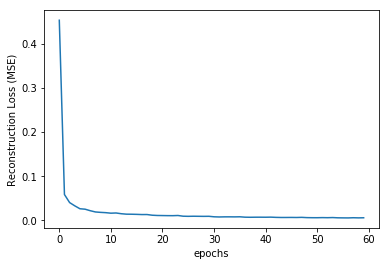

In [11]:
plt.plot(err)
plt.xlabel('epochs')
plt.ylabel('Reconstruction Loss (MSE)')

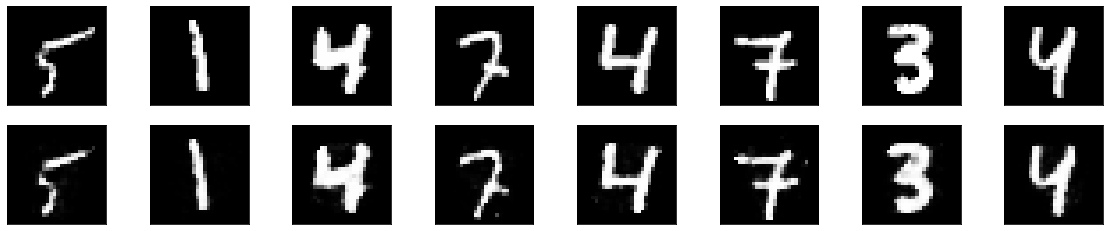

In [14]:
# Plotting original and reconstructed images
row, col = 2, 8
idx = np.random.randint(0, 100, row * col // 2)
f, axarr = plt.subplots(row, col, sharex=True, sharey=True,
figsize=(20,4))
for fig, row in zip([Xtest,out], axarr):
    for i,ax in zip(idx,row):
        ax.imshow(fig[i].reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)